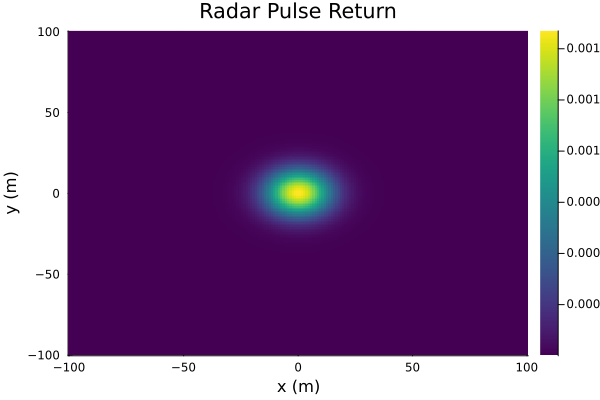

In [1]:
using Plots
using Distributions
using StaticArrays

# Define grid
x = LinRange(-100.0, 100.0, 200)
y = LinRange(-100.0, 100.0, 200)

# Simulate a simple 2D radar return with a target at center
heat = [pdf(MvNormal([0, 0], 10), [xi, yi]) for xi in x, yi in y]

# Plot heatmap of simulated pulse return
heatmap(x, y, heat, c=:viridis, xlabel="x (m)", ylabel="y (m)", title="Radar Pulse Return")


Propagated power at [4989.9799599198395, 4989.9799599198395]: 2.4666847650275794e-275
Propagated power at [4989.9799599198395, 4989.9799599198395]: 4.774740511582185e-144
Propagated power at [4989.9799599198395, 4989.9799599198395]: 3.438252020683177e-56
Propagated power at [4989.9799599198395, 4989.9799599198395]: 9.210377890162625e-12
Reflection at [5000.0, 5000.0] reflected power = 9.210377890162624e9
Propagated power at [4989.9799599198395, 4989.9799599198395]: 9.17844269995779e-11
Reflection at [5000.0, 5000.0] reflected power = 9.17844269995779e10
Propagated power at [4989.9799599198395, 4989.9799599198395]: 3.402611477199643e-53
Propagated power at [4989.9799599198395, 4989.9799599198395]: 4.6925351432057265e-139
Propagated power at [4989.9799599198395, 4989.9799599198395]: 2.4074346928367379e-268


┌ Info: Saved animation to /var/folders/vg/7_0bfbg14lz79gntg6h285yr0000gn/T/jl_7wLcLYlQBO.gif
└ @ Plots /Users/carson/.julia/packages/Plots/dIjan/src/animation.jl:156


Plots.AnimatedGif("/var/folders/vg/7_0bfbg14lz79gntg6h285yr0000gn/T/jl_7wLcLYlQBO.gif")
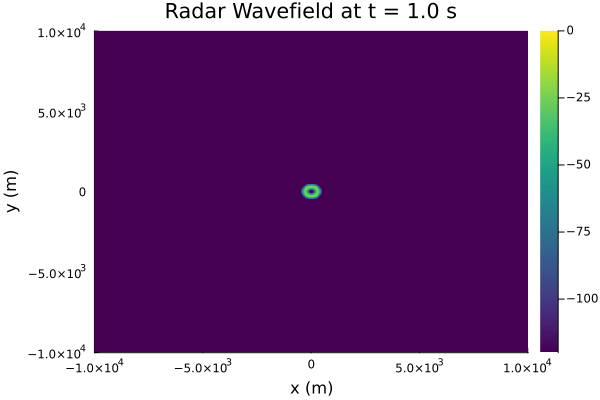

In [12]:
using StaticArrays
using LinearAlgebra
using Distributions
using Plots

abstract type AbstractTransmitter end

struct PointTransmitter <: AbstractTransmitter
    position::SVector{2, Float64}
    frequency::Float64
    power::Float64
    tx_time::Float64
    pulse_width::Float64
    #received_log::Vector{Float64}
    #transmitted_log::Vector{Float64}
end

mutable struct Reflector <: AbstractTransmitter
    position::SVector{2, Float64}
    pulse_width::Float64
    reflection_gain::Float64
    #received_log::Vector{Float64}
    #transmitted_log::Vector{Float64}
end

mutable struct RadarEnvironment
    grid_x::Vector{Float64}
    grid_y::Vector{Float64}
    wavefield::Matrix{Float64}
    transmitters::Vector{AbstractTransmitter}
    current_time::Float64
end

function RadarEnvironment(grid_x::Vector{Float64}, grid_y::Vector{Float64})
    wavefield = zeros(length(grid_x), length(grid_y))
    transmitters = AbstractTransmitter[]
    current_time = 0.0
    return RadarEnvironment(grid_x, grid_y, wavefield, transmitters, current_time)
end

function add_transmitter!(env::RadarEnvironment, tx::AbstractTransmitter)
    push!(env.transmitters, tx)
end

function pulse_amplitude(tx::PointTransmitter, t::Float64)
    return pdf(Normal(tx.tx_time, tx.pulse_width), t)
end

function rx_pulse_amplitude(center_time::Float64, rx::Reflector, t::Float64)
    return pdf(Normal(center_time, rx.pulse_width), t)
end

function propagate!(env::RadarEnvironment)
    env.wavefield .= 0.0

    for tx in env.transmitters
        if tx isa PointTransmitter
            pt = tx::PointTransmitter

            if env.current_time < pt.tx_time
                continue
            end

            for (i, xi) in enumerate(env.grid_x)
                for (j, yj) in enumerate(env.grid_y)
                    pos = SVector(xi, yj)
                    r = norm(pos - pt.position)

                    t_arrival = r / 300.0

                    amplitude = pulse_amplitude(pt, env.current_time - t_arrival)

                    if amplitude <= 0.0
                        continue
                    end

                    # Add propagated power
                    propagated_power = pt.power * amplitude / (r == 0 ? 1.0 : r^2)
                    env.wavefield[i, j] += propagated_power

                    # --- Check for reflectors ---
                    for rx in env.transmitters
                        if rx isa Reflector
                            refl = rx::Reflector

                            # Check if this grid point is near reflector
                            if norm(pos - rx.position) < 20.0
                                println("Propagated power at $(pos): ", propagated_power)
                                if propagated_power > 1e-12  # also lower threshold (optional)
                                    reflected_power = propagated_power * rx.reflection_gain
                                    # Loop over grid points again (local loop), propagate reflected_power outward
                                    for (ii, xii) in enumerate(env.grid_x)
                                        for (jj, yjj) in enumerate(env.grid_y)
                                            pos2 = SVector(xii, yjj)
                                            rr = norm(pos2 - rx.position)

                                            t_arrival_rr = rr / 300.0
                                            amplitude = rx_pulse_amplitude(env.current_time, rx, env.current_time - t_arrival)  # need dummy pulse shape for reflection

                                            if amplitude <= 0
                                                continue
                                            end

                                            env.wavefield[ii, jj] += reflected_power * amplitude / (rr == 0 ? 1.0 : rr^2)
                                        end
                                    end
                            
                                    println("Reflection at ", refl.position, " reflected power = ", reflected_power)
                                end
                            end
                        end
                    end
                end
            end
        end
    end
end


function step!(env::RadarEnvironment, dt::Float64)
    env.current_time += dt
    propagate!(env)
end

function plot_wavefield(env::RadarEnvironment)
    log_wavefield = 10 .* log10.(env.wavefield' .+ 1e-12)

    heatmap(env.grid_x, env.grid_y, log_wavefield, 
        c=:viridis, xlabel="x (m)", ylabel="y (m)", 
        title="Radar Wavefield at t = $(round(env.current_time, digits=2)) s",
        clims=(-120, 0))
end

# Setup and Animate


x = collect(LinRange(-10000.0, 10000.0, 500))
y = collect(LinRange(-10000.0, 10000.0, 500))
env = RadarEnvironment(x, y)

tx = PointTransmitter(SVector(0.0, 0.0), 100e9, 100.0, 0.0, 0.1)
add_transmitter!(env, tx)

rx = Reflector(SVector(5000.0, 5000.0), 0.1,10e20)
add_transmitter!(env, rx)

@gif for t = 1:40
    step!(env, 1.0)
    plot_wavefield(env)
end every 2
